In [78]:
# Referenced this: https://colab.research.google.com/drive/1CBIdPxHn_W2ARx4VozRLIptBrXk7ZBoM?usp=sharing#scrollTo=Q4ma6QCscwfB

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
# PyTorch
import torch
import torch.nn as nn 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from copy import deepcopy as dc

In [79]:
# Download data
stockPrices = yf.download("AMZN", start="2010-01-01")
stockPrices = stockPrices.dropna()
stockPrices = stockPrices.reset_index()
stockPrices = stockPrices.rename(columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Adj Close": "adjClose", "Volume": "volume"})

# Remove all stocks but adjusted close
stockPrices = stockPrices.drop(columns=["open", "high", "low", "close", "volume"])
print(stockPrices.head())

[*********************100%%**********************]  1 of 1 completed

        date  adjClose
0 2010-01-04    6.6950
1 2010-01-05    6.7345
2 2010-01-06    6.6125
3 2010-01-07    6.5000
4 2010-01-08    6.6760


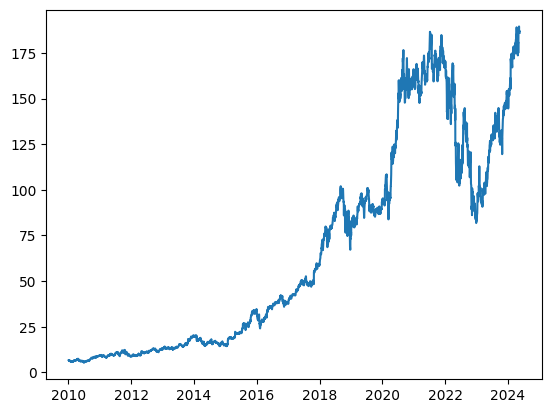

In [81]:
# Visualize data
plt.plot(stockPrices['date'], stockPrices['adjClose'])

In [82]:
# Setting index to date (will now not be referenced as part of the data when converted in Numpy)
stockPrices = stockPrices.set_index('date')

# Create lagged values to use as features
lags = 7

for i in range(lags, 0, -1):
    stockPrices[f'adjClose(t - {i})'] = stockPrices['adjClose'].shift(i)
    
# Drop field with empty lagged values (about 7 rows of data)
stockPrices = stockPrices.dropna()

print(stockPrices.head())    

            adjClose  adjClose(t - 7)  adjClose(t - 6)  adjClose(t - 5)   
date                                                                      
2010-01-13    6.4555           6.6950           6.7345           6.6125  \
2010-01-14    6.3675           6.7345           6.6125           6.5000   
2010-01-15    6.3570           6.6125           6.5000           6.6760   
2010-01-19    6.3805           6.5000           6.6760           6.5155   
2010-01-20    6.2890           6.6760           6.5155           6.3675   

            adjClose(t - 4)  adjClose(t - 3)  adjClose(t - 2)  adjClose(t - 1)  
date                                                                            
2010-01-13           6.5000           6.6760           6.5155           6.3675  
2010-01-14           6.6760           6.5155           6.3675           6.4555  
2010-01-15           6.5155           6.3675           6.4555           6.3675  
2010-01-19           6.3675           6.4555           6.3675        

In [83]:
# Transforming data

# Getting Numpy version of data so we can transform it
stockPricesAsNp = stockPrices.to_numpy()

# Adjusts array structure
scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalizes data
stockPricesAsNp = scaler.fit_transform(stockPricesAsNp)

print(stockPricesAsNp)

[[-0.9888629  -0.98622695 -0.98579672 ... -0.98646707 -0.98821097
  -0.98981907]
 [-0.98981907 -0.98579672 -0.98712555 ... -0.98821097 -0.98981907
  -0.9888629 ]
 [-0.98993315 -0.98712555 -0.98835091 ... -0.98981907 -0.9888629
  -0.98981907]
 ...
 [ 0.96816428  0.95283723  0.96906651 ...  0.98370181  1.
   0.97805172]
 [ 0.97359701  0.96906651  0.9961877  ...  1.          0.97805172
   0.96816428]
 [ 0.96186229  0.9961877   0.9968412  ...  0.97805172  0.96816428
   0.97359701]]


In [84]:
# Obtaining X matrix, and single y value (realized value based on all explanatory variables)

x = stockPricesAsNp[:, 1:]
y = stockPricesAsNp[:, 0]

print(x.shape, y.shape)

print("X")
print(x)
print("y")
print(y)

# TODO: analyze normalization of data

(3609, 7) (3609,)
X
[[-0.98622695 -0.98579672 -0.98712555 ... -0.98646707 -0.98821097
  -0.98981907]
 [-0.98579672 -0.98712555 -0.98835091 ... -0.98821097 -0.98981907
  -0.9888629 ]
 [-0.98712555 -0.98835091 -0.9864339  ... -0.98981907 -0.9888629
  -0.98981907]
 ...
 [ 0.95283723  0.96906651  0.9961877  ...  0.98370181  1.
   0.97805172]
 [ 0.96906651  0.9961877   0.9968412  ...  1.          0.97805172
   0.96816428]
 [ 0.9961877   0.9968412   0.98856327 ...  0.97805172  0.96816428
   0.97359701]]
y
[-0.9888629  -0.98981907 -0.98993315 ...  0.96816428  0.97359701
  0.96186229]


In [85]:
# Obtain data row to split training and test data
# 10% of the data will be test data, while 90% will be training data
trainingSplit = int(len(x) * 0.9)

# Split data
xTrain = x[:trainingSplit]
yTrain = y[:trainingSplit]

xTest = x[trainingSplit:]
yTest = y[trainingSplit:]

print(xTrain.shape, yTrain.shape, xTest.shape, yTest.shape)

(3248, 7) (3248,) (361, 7) (361,)


In [86]:
# Reshaping data to work with PyTorch
xTrain = xTrain.reshape((-1, lags, 1))
xTest = xTest.reshape((-1, lags, 1))

yTrain = yTrain.reshape((-1, 1))
yTest = yTest.reshape((-1, 1))

xTrain = torch.tensor(xTrain).float()
yTrain = torch.tensor(yTrain).float()
xTest = torch.tensor(xTest).float()
yTest = torch.tensor(yTest).float()

In [87]:
# Create dataset to train
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(xTrain, yTrain)
test_dataset = TimeSeriesDataset(xTest, yTest)

In [88]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [89]:
# Setting device to the CPU by default
device = 'cpu'

In [90]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch(optimizer, loss_function):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [ ]:
def validate_one_epoch(optimizer, loss_function):
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [ ]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(optimizer, loss_function)
    validate_one_epoch(optimizer)

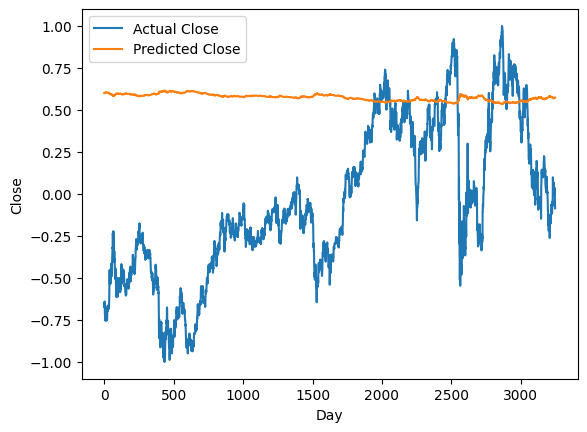

In [77]:
with torch.no_grad():
    predicted = model(xTrain.to(device)).to('cpu').numpy()

plt.plot(yTrain, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
test_predictions = model(xTest.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((xTest.shape[0], lags+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([59.73526823, 59.75577144, 59.76430192, 59.76461341, 59.74146331,
       59.7140693 , 59.72137279, 59.75582836, 59.771354  , 59.78990128,
       59.80001611, 59.77795386, 59.79616909, 59.79120892, 59.78762279,
       59.78038256, 59.76371372, 59.75712493, 59.73912157, 59.70221201,
       59.69731983, 59.67735264, 59.66533565, 59.64328605, 59.62287771,
       59.60579303, 59.57761634, 59.55876863, 59.57432273, 59.57723527,
       59.53403734, 59.50160252, 59.50466844, 59.4889578 , 59.47740251,
       59.4817397 , 59.48425536, 59.47310011, 59.47278704, 59.4698824 ,
       59.48872062, 59.49523352, 59.49152564, 59.49120308, 59.52143373,
       59.52508152, 59.50553018, 59.4859409 , 59.47408361, 59.47832118,
       59.4786975 , 59.5198984 , 59.52473049, 59.5212677 , 59.52719082,
       59.52077279, 59.51388674, 59.49039668, 59.48659868, 59.45842673,
       59.4555047 , 59.48048108, 59.49599407, 59.55623399, 59.57989166,
       59.68629898, 59.64534633, 59.71574061, 59.7095487 , 59.75

In [ ]:
dummies = np.zeros((xTest.shape[0], lags+1))
dummies[:, 0] = yTest.flatten()
dummies = scaler.inverse_transform(dummies)

new_yTest = dc(dummies[:, 0])
new_yTest

array([41.92992534, 41.9487013 , 42.10827394, 42.96245354, 43.73215278,
       43.15957038, 41.8829893 , 41.62955228, 41.23531838, 41.12267428,
       42.06134165, 41.29164251, 41.54507202, 41.6671042 , 41.8829893 ,
       42.38987124, 42.45557179, 42.97183381, 44.07945816, 43.88233743,
       44.40799139, 44.62388042, 45.23400704, 45.72210908, 46.07880242,
       46.85788213, 47.22397095, 46.39794769, 46.34163127, 47.95612213,
       48.79152972, 48.26587952, 48.71643734, 48.98864637, 48.67888937,
       48.57563691, 49.01680646, 48.95110987, 49.01680646, 48.2963932 ,
       48.21108519, 48.46701317, 48.4859763 , 47.37691369, 47.50013986,
       48.34378719, 48.92201886, 49.1210776 , 48.77983015, 48.74191179,
       47.24420042, 47.43378708, 47.7560795 , 47.56649659, 47.84139502,
       48.04992939, 48.81774811, 48.72294905, 49.62347333, 49.46233295,
       48.41962708, 48.0404498 , 46.06878127, 45.82232883, 42.40982973,
       44.93128404, 42.48565815, 43.24399352, 41.94534821, 41.79

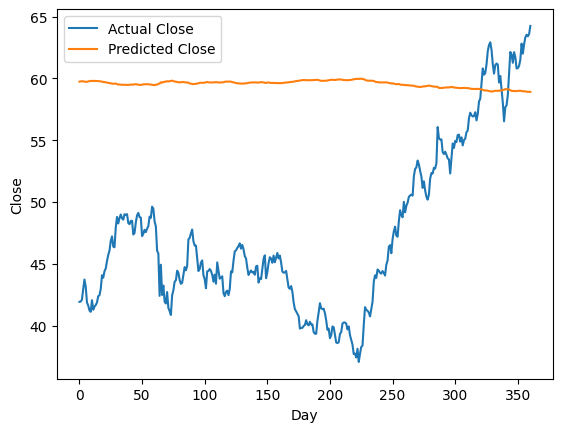

In [ ]:
plt.plot(new_yTest, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()